In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import random
import time

from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/DeepLearning/CS7643 Deep Learning Project/RelTR"
%load_ext autoreload
%autoreload 2
from models.backbone import Backbone, Joiner
from models.position_encoding import PositionEmbeddingSine
from models.transformer import Transformer
from models.reltr import RelTR

from PIL import Image
import requests
import matplotlib.pyplot as plt
from lib.evaluation.sg_eval import BasicSceneGraphEvaluator
import torch
import torch.nn.functional as F
from torchvision.ops import box_iou
from collections import defaultdict
import numpy as np
from models.matcher import build_matcher
from deecap import DeecapRelTR

CLASSES = [ 'N/A', 'airplane', 'animal', 'arm', 'bag', 'banana', 'basket', 'beach', 'bear', 'bed', 'bench', 'bike',
                'bird', 'board', 'boat', 'book', 'boot', 'bottle', 'bowl', 'box', 'boy', 'branch', 'building',
                'bus', 'cabinet', 'cap', 'car', 'cat', 'chair', 'child', 'clock', 'coat', 'counter', 'cow', 'cup',
                'curtain', 'desk', 'dog', 'door', 'drawer', 'ear', 'elephant', 'engine', 'eye', 'face', 'fence',
                'finger', 'flag', 'flower', 'food', 'fork', 'fruit', 'giraffe', 'girl', 'glass', 'glove', 'guy',
                'hair', 'hand', 'handle', 'hat', 'head', 'helmet', 'hill', 'horse', 'house', 'jacket', 'jean',
                'kid', 'kite', 'lady', 'lamp', 'laptop', 'leaf', 'leg', 'letter', 'light', 'logo', 'man', 'men',
                'motorcycle', 'mountain', 'mouth', 'neck', 'nose', 'number', 'orange', 'pant', 'paper', 'paw',
                'people', 'person', 'phone', 'pillow', 'pizza', 'plane', 'plant', 'plate', 'player', 'pole', 'post',
                'pot', 'racket', 'railing', 'rock', 'roof', 'room', 'screen', 'seat', 'sheep', 'shelf', 'shirt',
                'shoe', 'short', 'sidewalk', 'sign', 'sink', 'skateboard', 'ski', 'skier', 'sneaker', 'snow',
                'sock', 'stand', 'street', 'surfboard', 'table', 'tail', 'tie', 'tile', 'tire', 'toilet', 'towel',
                'tower', 'track', 'train', 'tree', 'truck', 'trunk', 'umbrella', 'vase', 'vegetable', 'vehicle',
                'wave', 'wheel', 'window', 'windshield', 'wing', 'wire', 'woman', 'zebra']

REL_CLASSES = ['__background__', 'above', 'across', 'against', 'along', 'and', 'at', 'attached to', 'behind',
                'belonging to', 'between', 'carrying', 'covered in', 'covering', 'eating', 'flying in', 'for',
                'from', 'growing on', 'hanging from', 'has', 'holding', 'in', 'in front of', 'laying on',
                'looking at', 'lying on', 'made of', 'mounted on', 'near', 'of', 'on', 'on back of', 'over',
                'painted on', 'parked on', 'part of', 'playing', 'riding', 'says', 'sitting on', 'standing on',
                'to', 'under', 'using', 'walking in', 'walking on', 'watching', 'wearing', 'wears', 'with']

from types import SimpleNamespace

device = "cuda" if torch.cuda.is_available() else "cpu"

args = {
    'bbox_loss_coef': 5,
    'giou_loss_coef': 2,
    'rel_loss_coef': 1,
    'aux_loss': False,
    'set_cost_class': 1,
    'set_cost_bbox': 5,
    'set_cost_giou': 2,
    'set_iou_threshold':0.7,
    'dataset': 'vg',
    'device': device,
    'eos_coef': 0.1,
    'seed': 42,
    'lr_backbone': 1e-5,
    'lr': 1e-4,
    'lr_drop': 200,
    'weight_decay': 1e-4,
    'ann_path': 'data/vg/',
    'img_folder': 'data/vg/images',
    'eval': True,
    'batch_size': 10,
    'epochs': 10,
    'num_workers': 2,
    'confidence_threshold': 0.7
}
args = SimpleNamespace(**args)

from deecap import DeecapRelTR
from models.backbone import build_backbone
from models.matcher import build_matcher
from models.transformer import build_transformer
from models.reltr import SetCriterion, PostProcess
from datasets import build_dataset
import util.misc as utils
from torch.utils.data import DataLoader, DistributedSampler

def build_model_for_eval(args):
  num_classes = 151 if args.dataset != 'oi' else 289 # some entity categories in OIV6 are deactivated.
  num_rel_classes = 51 if args.dataset != 'oi' else 31

  device = torch.device(args.device)

  matcher = build_matcher(args)

  model = DeecapRelTR(reltr_model)
  model.load_state_dict(torch.load('model weights/avg_mix_30_0.7.pth', map_location=torch.device('cuda')))

  model.to(device)

  weight_dict = {'loss_ce': 1, 'loss_bbox': args.bbox_loss_coef}
  weight_dict['loss_giou'] = args.giou_loss_coef
  weight_dict['loss_rel'] = args.rel_loss_coef

  # TODO this is a hack
  if args.aux_loss:
      aux_weight_dict = {}
      for i in range(args.dec_layers - 1):
          aux_weight_dict.update({k + f'_{i}': v for k, v in weight_dict.items()})
      weight_dict.update(aux_weight_dict)

  losses = ['labels', 'boxes', 'cardinality', "relations"]

  criterion = SetCriterion(num_classes, num_rel_classes, matcher=matcher, weight_dict=weight_dict,
                            eos_coef=args.eos_coef, losses=losses)
  criterion.to(device)
  postprocessors = {'bbox': PostProcess()}
  return model, criterion, postprocessors

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
import engine
from collections import Counter

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1qHoaQqsa_84wKp4XFuiBiBUnxjcdMWJm/CS7643 Deep Learning Project/RelTR


In [ ]:
position_embedding = PositionEmbeddingSine(128, normalize=True)
backbone = Backbone('resnet50', False, False, False)
backbone = Joiner(backbone, position_embedding)
backbone.num_channels = 2048

transformer = Transformer(d_model=256, dropout=0.1, nhead=8,
                          dim_feedforward=2048,
                          num_encoder_layers=6,
                          num_decoder_layers=6,
                          normalize_before=False,
                          return_intermediate_dec=True)

reltr_model = RelTR(backbone, transformer, num_classes=151, num_rel_classes = 51,
              num_entities=100, num_triplets=200)

# The checkpoint is pretrained on Visual Genome
device = "cuda" if torch.cuda.is_available() else "cpu"
ckpt = torch.load('ckpt/checkpoint0149.pth', map_location=torch.device(device), weights_only=False)
reltr_model.load_state_dict(ckpt['model'])
reltr_model.eval()
for param in reltr_model.parameters():
    param.requires_grad = False

utils.init_distributed_mode(args)

device = torch.device(args.device)

# fix the seed for reproducibility
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

model, criterion, postprocessors = build_model_for_eval(args)
model.to(device)

dataset_test = build_dataset(image_set='val', args=args)

sampler_test = torch.utils.data.SequentialSampler(dataset_test)

# small_indices = list(range(20))  
# sampler_test = torch.utils.data.SubsetRandomSampler(small_indices)

data_loader_test = DataLoader(dataset_test, args.batch_size, sampler=sampler_test,
                             drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)

base_ds = get_coco_api_from_dataset(dataset_test)
entropy_distribution = dict()
for entropy in [0.60,0.55,0.50,0.45, 0.40]:
  if args.eval:
      args.confidence_threshold = entropy
      print("Entropy Level: ", entropy)
      test_stats, coco_evaluator, all_exit_layers = engine.evaluate(model, criterion, postprocessors, data_loader_test, base_ds, device, args)
      entropy_distribution[entropy] = dict(Counter(all_exit_layers))
      print(entropy_distribution[entropy])

Not using distributed mode
loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
Entropy Level:  0.6
Test:  [  0/292]  eta: 0:16:43  class_error: 37.42  sub_error: 58.02  obj_error: 53.09  rel_error: 76.54  loss: 4.2446 (4.2446)  loss_ce: 0.6611 (0.6611)  loss_bbox: 1.2025 (1.2025)  loss_giou: 1.4953 (1.4953)  loss_rel: 0.8857 (0.8857)  loss_ce_unscaled: 0.6611 (0.6611)  class_error_unscaled: 37.4233 (37.4233)  sub_error_unscaled: 58.0247 (58.0247)  obj_error_unscaled: 53.0864 (53.0864)  loss_bbox_unscaled: 0.2405 (0.2405)  loss_giou_unscaled: 0.7477 (0.7477)  cardinality_error_unscaled: 3.9000 (3.9000)  loss_rel_unscaled: 0.8857 (0.8857)  rel_error_unscaled: 76.5432 (76.5432)  time: 3.4350  data: 1.6808  max mem: 6025
Test:  [100/292]  eta: 0:06:53  class_error: 39.55  sub_error: 52.38  obj_error: 47.62  rel_error: 63.49  loss: 3.9737 (3.9091)  loss_ce: 0.5636 (0.5619)  loss_bbox: 1.2604 (1.2426)  loss_giou: 1.3530 (1.3566)  loss_rel: 0.7668 (0.7479)  loss

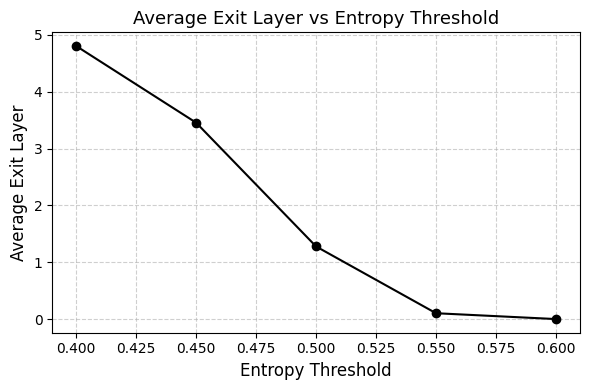

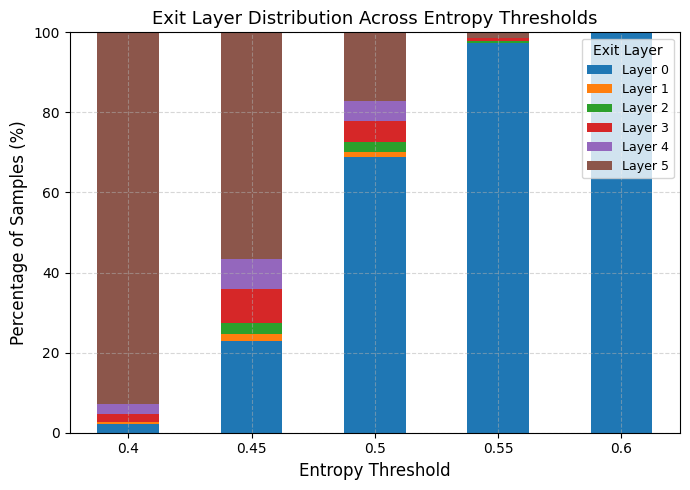

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

exit_data = { # gathered from logs.
    0.6: {0: 292},
    0.55: {0: 284, 5: 3, 2: 2, 3: 2},
    0.5: {0: 201, 4: 15, 1: 4, 3: 15, 5: 13, 2: 7},
    0.45: {5: 17, 4: 22, 0: 67, 3: 25, 2: 8, 1: 5},
    0.4: {3: 6, 1: 2, 5: 10, 4: 7, 0: 6}
}

total_samples = 292
max_layer = 5

entropy_levels = []
avg_exit_layers = []
layers = list(range(max_layer + 1))
stacked_percentages = {layer: [] for layer in layers}

for entropy, exits in sorted(exit_data.items()):
    counts = [exits.get(layer, 0) for layer in layers]
    exited_samples = sum(counts)
    missing = total_samples - exited_samples
    counts[-1] += missing

    avg_exit = sum(layer * count for layer, count in enumerate(counts)) / total_samples

    entropy_levels.append(entropy)
    avg_exit_layers.append(avg_exit)

    for layer in layers:
        percentage = counts[layer] / total_samples * 100
        stacked_percentages[layer].append(percentage)


plt.figure(figsize=(6, 4))
plt.plot(entropy_levels, avg_exit_layers, marker='o', linestyle='-', color='black')
plt.xlabel('Entropy Threshold', fontsize=12)
plt.ylabel('Average Exit Layer', fontsize=12)
plt.title('Average Exit Layer vs Entropy Threshold', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(7, 5))

bar_width = 0.5
x = np.arange(len(entropy_levels))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

bottom = np.zeros(len(entropy_levels))

for idx, layer in enumerate(layers):
    percentages = stacked_percentages[layer]
    ax.bar(x, percentages, bottom=bottom, width=bar_width, label=f'Layer {layer}', color=colors[idx])
    bottom += np.array(percentages)

ax.set_xlabel('Entropy Threshold', fontsize=12)
ax.set_ylabel('Percentage of Samples (%)', fontsize=12)
ax.set_title('Exit Layer Distribution Across Entropy Thresholds', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels([str(e) for e in sorted(exit_data.keys())], fontsize=10)
plt.yticks(fontsize=10)
ax.legend(title='Exit Layer', fontsize=9, title_fontsize=10)
ax.grid(True, linestyle='--', alpha=0.5)

plt.ylim(0, 100)
plt.tight_layout()
plt.show()
